Target: 
        Increase the network capacity by increasing layers and channel sizes 
        achieve accuracy around 99.3%

Result:
        Parameters: 7822
        train accuracy: 98.75%
        test accuracy: 99.33% [Epoch 17)

Analysis:
        Network capacity is good and learning to fullest.
        Room to increase test accuracy by implementing data augmentation
        and learning rate scheduling.



In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Data Transformations
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Statistics
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('Train Data Stats:')
print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
print('- Tensor shape ', train.train_data.size())
print('- Min ', torch.min(train_data))
print('- Max ', torch.max(train_data))
print('- mean ', torch.mean(train_data))
print('- Std ', torch.std(train_data))
print('- var ', torch.var(train_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train Data Stats:
- Numpy Shape  (60000, 28, 28)
- Tensor shape  torch.Size([60000, 28, 28])
- Min  tensor(-0.4242)
- Max  tensor(2.8215)
- mean  tensor(-0.0001)
- Std  tensor(1.0000)
- var  tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


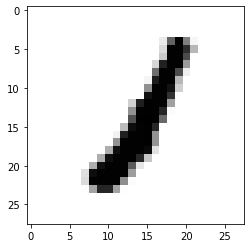

In [ ]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

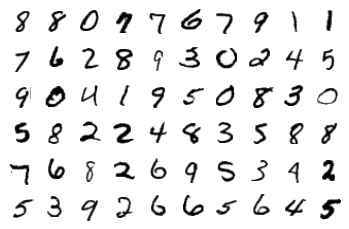

In [ ]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [ ]:
dropout_value = 0.10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout_value)
    )#output_size=26
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout_value)
    )#output_size=24

    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        #nn.ReLU()
    )#output_size=22

    self.pool1 = nn.MaxPool2d(2,2)#output_size=11


    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout_value)
    )#output_size=11

    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout_value)
    )#output_size=9

    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout_value)
    )#output_size=7

    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout_value)
    )#output_size=7

    #output block
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    )#output_size=1

    self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
    )#output_size=7


  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.gap(x)
    x = self.convblock8(x)

    x = x.view(-1, 10)

    return F.log_softmax(x, dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,016
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,440
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             120
             ReLU-12           [-1, 12, 11, 11]               0
      BatchNorm2d-13           [-1, 12, 11, 11]              24
          Dropout-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1668226569890976 Batch_id=468 Accuracy=84.13: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.1196, Accuracy: 9649/10000 (96.49%)

EPOCH: 1


Loss=0.1047634705901146 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.1016, Accuracy: 9703/10000 (97.03%)

EPOCH: 2


Loss=0.04049765691161156 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.0529, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.05139198899269104 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0468, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.10422759503126144 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.0401, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.10971980541944504 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0405, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.05643478035926819 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0371, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.04364138841629028 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]



Test set: Average loss: 0.0385, Accuracy: 9884/10000 (98.84%)

EPOCH: 8


Loss=0.048056408762931824 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:18<00:00, 25.52it/s]



Test set: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.01796933263540268 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0324, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.08794979006052017 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.07196401804685593 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0284, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.014689628034830093 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0300, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.03950396552681923 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]



Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.07357856631278992 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0297, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.017960552126169205 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]



Test set: Average loss: 0.0299, Accuracy: 9904/10000 (99.04%)

EPOCH: 16


Loss=0.05481283366680145 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]



Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.11067680269479752 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.014417304657399654 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]



Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 19


Loss=0.09982195496559143 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0271, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

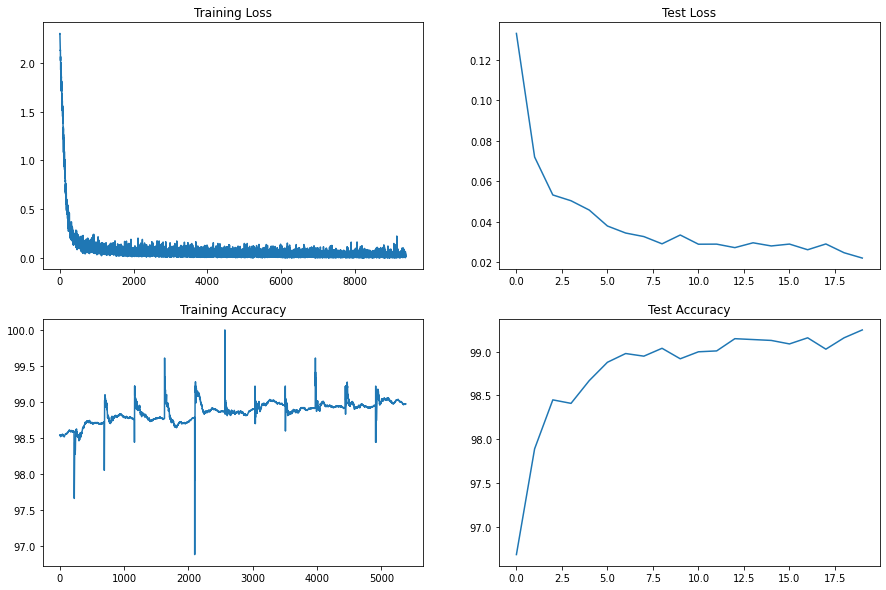

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")